In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

%matplotlib inline

## Load both well-level data and synthesis summary data

In [2]:
df = pd.read_csv('synthetic_data.csv')

In [3]:
df.head()

,synthesis_id,well_position,pure_yield,full_length_product,n-1,n+1,cyanoethyl,other_impurity,well_position_label
0,1,0,32.137910,67.216778,4.681915,7.522566,2.143953,1.794738e-293,A1
1,1,1,34.102792,66.812247,3.046022,3.841760,1.748832,0.000000e+00,A2
2,1,2,36.291145,65.550430,5.348962,4.746564,2.536760,4.552129e-112,A3
3,1,3,31.898187,64.316842,4.468409,2.734823,1.598658,0.000000e+00,A4
4,1,4,31.898228,66.387917,7.550588,2.743191,1.564808,0.000000e+00,A5


In [4]:
synthesis_df = pd.read_csv('synthetic_synthesis_data.csv')

In [5]:
synthesis_df.head()

,cyanoethyl,cyanoethyl_std,full_length_product,full_length_product_std,n+1,n+1_std,n-1,n-1_std,other_impurity,other_impurity_std,pure_yield,pure_yield_left,pure_yield_right,pure_yield_std,synthesis_id
0,2.200573,0.330459,66.944464,2.649496,3.455595,1.841868,3.627929,1.611462,0.048238,0.185853,32.199379,32.072160,32.326599,2.310163,1
1,2.070642,0.324617,77.306542,2.650520,2.208966,1.614841,2.055224,1.415506,0.004314,0.035018,32.754828,33.003157,32.506498,2.516568,2
2,2.153704,0.295581,70.074465,2.719915,2.524476,1.764937,2.459956,1.442385,0.138598,0.262326,26.431237,26.687269,26.175206,2.331140,3
3,1.631276,0.352804,83.313487,3.252847,1.449001,1.368400,1.617999,1.361580,0.086390,0.217208,36.596891,36.863375,36.330407,2.590460,4
4,1.899983,0.318029,79.149523,2.852997,1.664587,1.547128,2.328662,1.402436,0.139353,0.280002,23.218476,23.451603,22.985349,2.671462,5


In [6]:
# Get baseline synthesis mean and standard deviaiton for pure yield
'Pure Yield: {} +/- {} nmol'.format(synthesis_df.pure_yield.mean(), synthesis_df.pure_yield.std())

'Pure Yield: 29.95269877025627 +/- 5.024873643249136 nmol'

/Users/aaron.wiegel/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


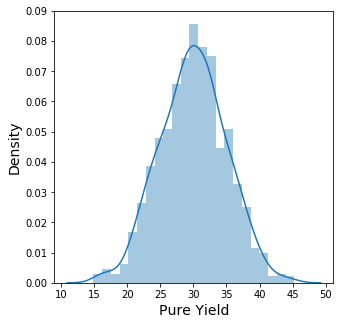

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(synthesis_df.pure_yield)
ax.set_xlabel('Pure Yield', fontsize=14)
ax.set_ylabel('Density', fontsize=14);

## Simple power simulation

We want to test whether a process change will improve our pure yield. Luckily, we know our baseline "population" pure yield, assuming our pure yields do not drift over time. We then declare the null and alternative hypotheses for this test:

$H_0: \mu = 29.95$ nmol

$H_a: \mu > 29.95$ nmol

We can set the significance level for whatever resulting hypothesis test we would like to perform at the customary level of 5%. This determines our false positive rate, i.e., how often we would reject the null hypothesis when nothing has actually changed. How do we avoid false negatives, though? (When we don't reject the null hypothesis when we should.) In other words, how many times should we run experiments before we can be reasonably sure that we haven't actually improved pure yield?

For that we can use power simulations. (Sometimes it's possible to calculate this directly, but I think simulations better illustrate the concepts.) We need to figure out an acceptable false negative rate (customarily set to 20%). Importantly, we also need to assume something about the _expected_ effect size. To start, we will assume a 10% effect size but relax this assumption later.

In [26]:
effect_size = 1.10
false_negative_rate = 0.2
population_pure_yield = synthesis_df['pure_yield'].mean()
n_experiments = 3
n_experiments_max = 31


Let's start by considering an experiment with 3 replicates (and recall that a synthesis, not a well, is a replicate.) We want to find pure yield under the null hypothesis, and the pure yield under the alternative hypothesis (assuming an effect size of 10%)

In [27]:

# Set random number seed to ensure reproducibility
np.random.seed(42)
results = []
for i in range(n_experiments, n_experiments_max):
    for _ in range(1000):
        sample_null = synthesis_df.sample(n=i)
        sample_alt = synthesis_df.sample(n=i)

        sample_alt['pure_yield'] = sample_alt['pure_yield'] * effect_size

        t_null = scipy.stats.ttest_1samp(sample_null['pure_yield'], population_pure_yield)[0]
        t_alt = scipy.stats.ttest_1samp(sample_alt['pure_yield'], population_pure_yield)[0]

        data = {
            'n_experiments': i,
            'pure_yield_null': sample_null['pure_yield'].mean(),
            'pure_yield_null_std': sample_null['pure_yield'].std(),
            't_stat_null': t_null,
            # Convert two-sided results to one-sided
            'p_value_null': 1 - scipy.stats.t.cdf(t_null, i - 1),
            'pure_yield_alt': sample_alt['pure_yield'].mean(),
            'pure_yield_alt_std': sample_alt['pure_yield'].std(),
            't_stat_alt': t_alt,
            # Convert two-sided results to one-sided
            'p_value_alt': 1 - scipy.stats.t.cdf(t_alt, i - 1),
        }
        results.append(data)
    
sample_df = pd.DataFrame(results)

In [28]:
sample_df.head()

,n_experiments,p_value_alt,p_value_null,pure_yield_alt,pure_yield_alt_std,pure_yield_null,pure_yield_null_std,t_stat_alt,t_stat_null
0,3,0.304788,0.067539,31.897184,5.615665,31.863834,1.358257,0.599742,2.437082
1,3,0.061174,0.520054,32.967144,2.016208,29.772254,5.505755,2.589600,-0.056766
2,3,0.472715,0.431807,30.208194,5.725612,31.327546,12.230676,0.077290,0.194699
3,3,0.090533,0.767561,31.656365,1.462207,26.698130,6.292575,2.018069,-0.895830
4,3,0.218402,0.310306,33.812344,6.935590,33.392210,10.273352,0.963884,0.579889


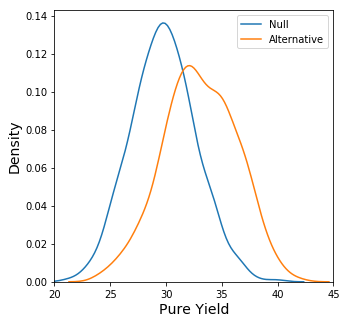

In [52]:
mask = sample_df.n_experiments == 3
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(sample_df[mask].pure_yield_null, hist=False, ax=ax, label='Null')
sns.distplot(sample_df[mask].pure_yield_alt, hist=False, ax=ax, label='Alternative')
ax.set_xlabel('Pure Yield', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([20, 45])
fig.savefig('null_alt_comp_n_3.png', dpi=150, bbox_inches='tight');

In [30]:
sample_df.describe()

,n_experiments,p_value_alt,p_value_null,pure_yield_alt,pure_yield_alt_std,pure_yield_null,pure_yield_null_std,t_stat_alt,t_stat_null
count,28000.000000,2.800000e+04,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000
mean,16.500000,8.905536e-02,0.499533,32.949394,5.379292,29.944082,4.899923,2.288183,0.002588
std,8.077891,1.503305e-01,0.287042,1.638756,1.208392,1.481280,1.116128,1.502211,1.188825
min,3.000000,9.336097e-09,0.000114,23.912563,0.135053,17.878256,0.173811,-8.714433,-15.713847
25%,9.750000,3.849531e-03,0.249889,32.004290,4.682990,29.075880,4.259642,1.386492,-0.699058
50%,16.500000,2.350977e-02,0.498850,32.935819,5.383203,29.956240,4.898581,2.226143,0.002954
75%,23.250000,1.018230e-01,0.749371,33.900340,6.084023,30.820737,5.540579,3.093448,0.698157
max,30.000000,9.995560e-01,0.999987,41.983158,15.080706,40.056910,12.988582,85.769206,43.477496


In [31]:
sample_df['reject_null_alt'] = sample_df['p_value_alt'] < 0.05
sample_df['reject_null_null'] = sample_df['p_value_null'] < 0.05

In [32]:
sample_df['reject_null_alt'].mean(), sample_df['reject_null_null'].mean()

(0.6281071428571429, 0.047392857142857146)

In [33]:
sample_df.loc[sample_df.n_experiments == 3, 'reject_null_alt'].mean()

0.172

In [34]:
results = []
for n_experiments, group in sample_df.groupby('n_experiments'):
    data = {
        'n_experiments': n_experiments,
        'reject_null_alt': group['reject_null_alt'].mean(),
        'reject_null_null': group['reject_null_null'].mean()
    }
    results.append(data)
power_df = pd.DataFrame(results)

In [39]:
power_df['false_negative_rate'] = 1 - power_df['reject_null_alt']

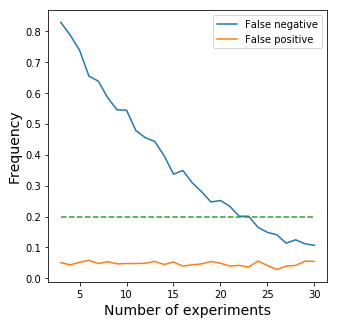

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(power_df['n_experiments'], power_df['false_negative_rate'], label='False negative')
ax.plot(power_df['n_experiments'], power_df['reject_null_null'], label='False positive')
ax.plot([3, 30], [0.2, 0.2], '--')
ax.legend()
ax.set_xlabel('Number of experiments', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
fig.savefig('type1_type2_comparison.png', dpi=150, bbox_inches='tight');

In [49]:
experiment_mask = sample_df.n_experiments == 22

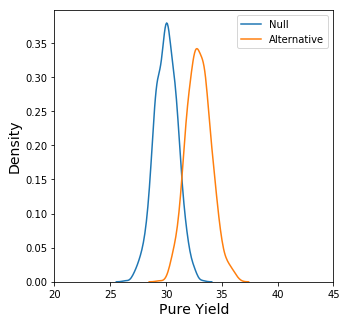

In [53]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(sample_df[experiment_mask].pure_yield_null, hist=False, ax=ax, label='Null')
sns.distplot(sample_df[experiment_mask].pure_yield_alt, hist=False, ax=ax, label='Alternative')
ax.set_xlabel('Pure Yield', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([20, 45])
fig.savefig('null_alt_comp_n_22.png', dpi=150, bbox_inches='tight');

## Issues with a particular side

In [55]:
df['other_impurity_pass'] = df['other_impurity'] < 0.03

In [59]:
bottom_mask = df.well_position_label.str.contains('H')

In [61]:
df.loc[bottom_mask, 'other_impurity_pass'].mean()

0.6570833333333334

In [62]:
df.loc[~bottom_mask, 'other_impurity_pass'].mean()

0.891095238095238

In [72]:
results = []
for synthesis_id, group in df.groupby('synthesis_id'):
    data = {
        'synthesis_id': synthesis_id,
        'bottom_pure_yield': group.loc[bottom_mask, 'pure_yield'].mean(),
        'top_pure_yield': group.loc[~bottom_mask, 'pure_yield'].mean(),
        'overall_pass_rate': group['other_impurity_pass'].mean(),
        'bottom_pass_rate': group.loc[bottom_mask, 'other_impurity_pass'].mean(),
        'top_pass_rate': group.loc[~bottom_mask, 'other_impurity_pass'].mean(),
    }
    results.append(data)
position_df = pd.DataFrame(results)

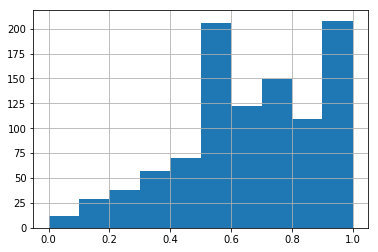

In [66]:
position_df['bottom_pass_rate'].hist()

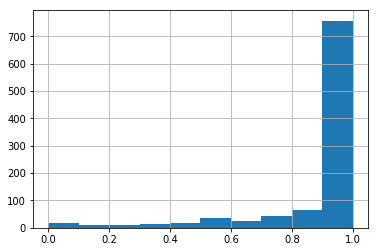

In [67]:
position_df['top_pass_rate'].hist()

In [78]:
position_df['pass_rate_diff'] = position_df['bottom_pass_rate'] - position_df['top_pass_rate']

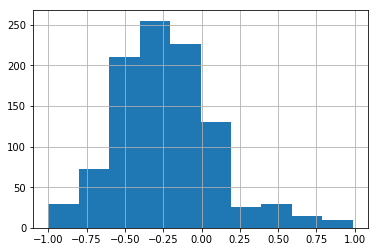

In [69]:
position_df['pass_rate_diff'].hist()

In [100]:
position_df['pass_rate_diff'].mean()

-0.23401190476190475

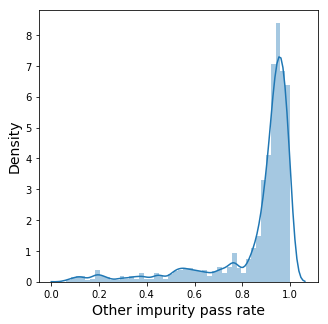

In [75]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(position_df['overall_pass_rate'], ax=ax)
ax.set_xlabel('Other impurity pass rate', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig('other_impurity_pass_rate.png', dpi=150, bbox_inches='tight')

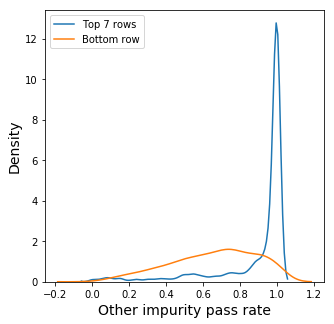

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(position_df['top_pass_rate'], ax=ax, hist=False, label='Top 7 rows')
sns.distplot(position_df['bottom_pass_rate'], ax=ax, hist=False, label='Bottom row')
ax.set_xlabel('Other impurity pass rate', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig('other_impurity_pass_rate_comparison.png', dpi=150, bbox_inches='tight')

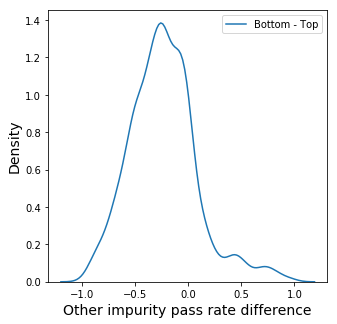

In [81]:
 fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(position_df['pass_rate_diff'], ax=ax, label='Bottom - Top', hist=False)
ax.set_xlabel('Other impurity pass rate difference', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig('other_impurity_pass_rate_difference.png', dpi=150, bbox_inches='tight')

In [85]:
results = []
for i in range(2, 5):
    for _ in range(1000):
        sample = position_df.sample(n=i)
        data = {
            'sample_size': i,
            'pass_rate_difference_mean': sample['pass_rate_diff'].mean()
        }
        results.append(data)
sample_df = pd.DataFrame(results)

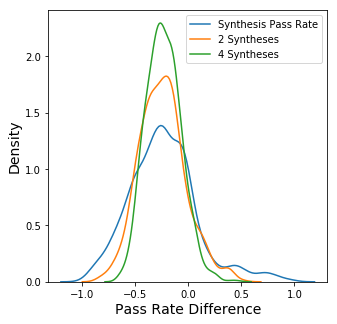

In [91]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(position_df['pass_rate_diff'], ax=ax, label='Synthesis Pass Rate', hist=False)
sns.distplot(sample_df.loc[sample_df['sample_size'] == 2,
                       'pass_rate_difference_mean'], ax=ax, label='2 Syntheses', hist=False)
sns.distplot(sample_df.loc[sample_df['sample_size'] == 4,
                           'pass_rate_difference_mean'], ax=ax, label='4 Syntheses', hist=False)
ax.set_xlabel('Pass Rate Difference', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
fig.savefig('sampling_pass_rate_differences.png', dpi=150, bbox_inches='tight')

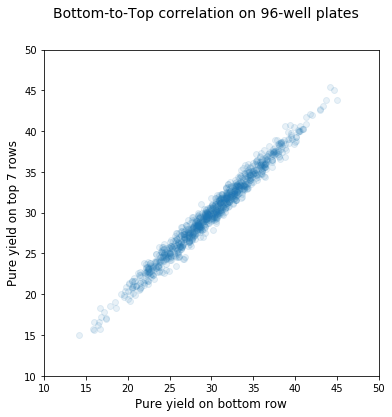

In [99]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle('Bottom-to-Top correlation on 96-well plates', fontsize=14)
ax.set_xlabel('Pure yield on bottom row', fontsize=12)
ax.set_ylabel('Pure yield on top 7 rows', fontsize=12)
ax.set_xlim([10, 50])
ax.set_ylim([10, 50])
plt.scatter(position_df['bottom_pure_yield'],
            position_df['top_pure_yield'], alpha=0.1)
fig.savefig('bottom_top_pure_yield.png', bbox_inches='tight', dpi=150);

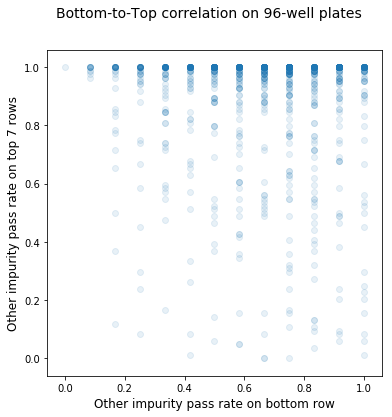

In [98]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle('Bottom-to-Top correlation on 96-well plates', fontsize=14)
ax.set_xlabel('Other impurity pass rate on bottom row', fontsize=12)
ax.set_ylabel('Other impurity pass rate on top 7 rows', fontsize=12)
plt.scatter(position_df['bottom_pass_rate'],
            position_df['top_pass_rate'], alpha=0.1)
fig.savefig('bottom_top_pass_rate.png', bbox_inches='tight', dpi=150);

In [101]:
results = []
population_pass_rate_diff = -0.234
synthesis_ids = df.synthesis_id.unique()
for i in range(2, 6):
    for _ in range(1000):
        random_ids = np.random.choice(synthesis_ids, replace=False, size=i)
        
        bottom_pass = []
        bottom_pass_fixed = []
        top_pass = []
        
        for id_ in random_ids:
            synthesis_mask = df.synthesis_id == id_
            fixed_sample = df[synthesis_mask & ~bottom_mask].sample(n=12, replace=True)
            
            bottom_pass.append(df.loc[synthesis_mask & bottom_mask, 'other_impurity_pass'].mean())
            bottom_pass_fixed.append(fixed_sample['other_impurity_pass'].mean())
            top_pass.append(df.loc[synthesis_mask & ~bottom_mask, 'other_impurity_pass'].mean())
        
        pass_rate_diff = np.array(bottom_pass) - np.array(top_pass)
        pass_rate_diff_fixed = np.array(bottom_pass_fixed) - np.array(top_pass)
        
        t_null = scipy.stats.ttest_1samp(pass_rate_diff, population_pass_rate_diff)[0]
        t_alt = scipy.stats.ttest_1samp(pass_rate_diff_fixed, population_pass_rate_diff)[0]
        
        data = {
            'n_experiments': i,
            'pass_rate_diff_null': np.mean(pass_rate_diff),
            't_stat_null': t_null,
            # Convert two-sided results to one-sided
            'p_value_null': 1 - scipy.stats.t.cdf(t_null, i - 1),
            'pass_rate_diff_alt': np.mean(pass_rate_diff_fixed),
            't_stat_alt': t_alt,
            # Convert two-sided results to one-sided
            'p_value_alt': 1 - scipy.stats.t.cdf(t_alt, i - 1),
        }
        
        results.append(data)

pass_rate_df = pd.DataFrame(results)

In [104]:
pass_rate_df['reject_null_alt'] = pass_rate_df['p_value_alt'] < 0.05
pass_rate_df['reject_null_null'] = pass_rate_df['p_value_null'] < 0.05

In [108]:
results = []
for n_experiments, group in pass_rate_df.groupby('n_experiments'):
    data = {
        'n_experiments': n_experiments,
        'false_positive_rate': group['reject_null_null'].mean(),
        'false_negative_rate': 1 - group['reject_null_alt'].mean()
    }
    results.append(data)
power_pass_df = pd.DataFrame(results)

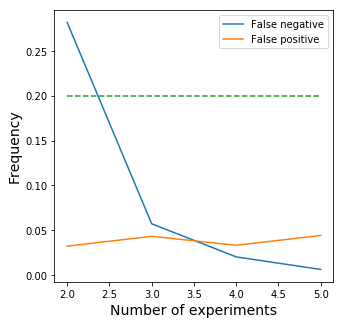

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(power_pass_df['n_experiments'], power_pass_df['false_negative_rate'], label='False negative')
ax.plot(power_pass_df['n_experiments'], power_pass_df['false_positive_rate'], label='False positive')
ax.plot([2, 5], [0.2, 0.2], '--')
ax.legend()
ax.set_xlabel('Number of experiments', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
fig.savefig('type1_type2_pass_rate_comparison.png', dpi=150, bbox_inches='tight');